In [227]:
#librerías
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Pregunta 1 : Proceso vasicek

Suponga que su empresa emite el 18-6-2025 un bono bullet por 100 mil millones de pesos a 12 meses plazo con tasa cupón compuesta semi anualmente, igual a 4,4%. Usando la información en Canvas, se pide que calibre un proceso de Vasicek para la tasa a 6 meses plazo

In [228]:
#data
df = pd.read_excel('DatosTarea.xlsx', parse_dates=['Date'], decimal=',')
df = df.sort_values('Date',ascending=True)  # x orden cronológico
df

,Date,1M,2M,3M,6M,9M,1Y,18M,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
455,2023-08-16,9.941,9.600,9.1450,8.655,7.8900,7.5875,6.6800,6.1350,5.7250,5.5400,5.5200,5.4250,5.390,5.3250,5.3150,5.4625
454,2023-08-17,9.899,9.620,9.1500,8.505,7.9400,7.3900,6.8275,6.2500,5.8550,5.6350,5.3925,5.3300,5.475,5.3700,5.3900,5.4550
453,2023-08-18,9.815,9.600,9.1900,8.510,7.9500,7.3750,6.8430,6.2475,5.8425,5.6350,5.3250,5.2900,5.470,5.3250,5.3150,5.3350
452,2023-08-21,9.820,9.581,9.2450,8.540,8.1250,7.4350,6.6625,6.1000,5.6750,5.5000,5.3570,5.2700,5.350,5.2950,5.2950,5.2750
451,2023-08-22,9.760,9.525,9.2375,8.560,8.1300,7.4350,6.6380,6.0550,5.6400,5.4350,5.3370,5.3300,5.290,5.2850,5.2850,5.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2025-06-12,4.960,4.937,4.8750,4.745,4.6625,4.5850,4.5300,4.4100,4.4800,4.5800,4.6700,4.7700,4.860,4.9600,5.0375,5.1200
3,2025-06-13,4.945,4.930,4.8800,4.760,4.6800,4.6200,4.5500,4.4275,4.5025,4.5975,4.6950,4.7900,4.875,4.9725,5.0450,5.1300
2,2025-06-16,4.940,4.930,4.8575,4.730,4.6560,4.6000,4.5320,4.4100,4.4900,4.5850,4.6800,4.7800,4.875,4.9700,5.0425,5.1250
1,2025-06-17,4.920,4.872,4.8350,4.735,4.6500,4.5925,4.5275,4.4025,4.4850,4.5850,4.6800,4.7775,4.870,4.9650,5.0450,5.1275


In [229]:
r = df['6M'].dropna().values / 100  # decimales

A continuación se estiman los parámetros theta, mu y sigma para el modelo Vasicek: 
dr = theta ( mu - r ) + sigma*dW con dW un proceso Weiner. El primer término es determinístico y el segundo estocástico. 

Como los datos obtenidos son diarios, para estimar los parámetros se considerará un dt diario (dt=1/360).

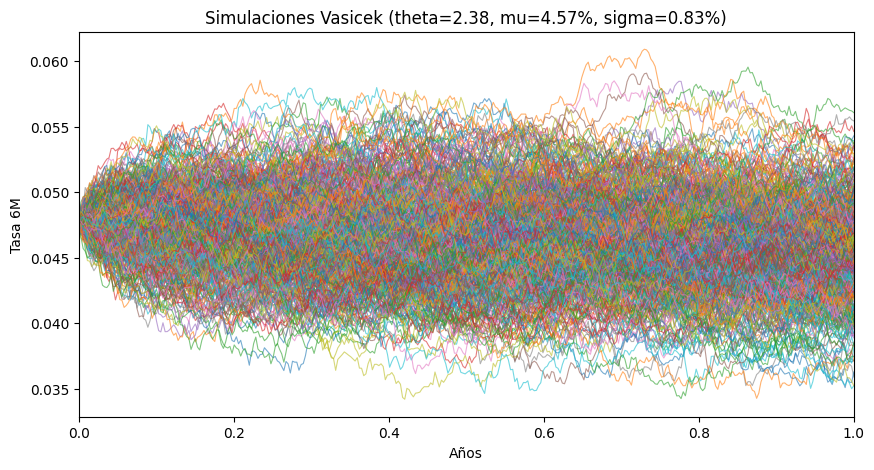

,Parámetro,Valor
0,theta,2.376486
1,mu (%),4.566871
2,sigma (%),0.828700


In [254]:
#parámetros para la calibración
r_lag = r[:-1]
dr = r[1:] - r_lag #delta_r
dt_cal = 1/360 #calibración diaria
r0 = r[-1] # corresponde a la tasa hoy: 0.0479 según el excel
T = 1.0 
sims = 500

# matriz de diseño y OLS
X = np.column_stack([np.ones_like(r_lag), r_lag])
(theta_hat, *_ ) = np.linalg.lstsq(X, dr, rcond=None)
alpha_hat, beta_hat = theta_hat

# estimación de sigma de los residuos
N = len(dr)
resid = dr - (alpha_hat + beta_hat * r_lag)
sigma_eps = np.sqrt(np.sum(resid**2) / (N - 2))
sigma = sigma_eps / np.sqrt(dt_cal)

#definimos theta y mu
theta = -beta_hat / dt_cal
mu = alpha_hat / (theta * dt_cal)

#vasicek
def vasicek_model(theta, mu, sigma, r0, T, dt_cal):
    N = int(T / dt_cal)
    rates = np.zeros(N)
    rates[0] = r0
    for t in range(1, N):
        dr = theta * (mu - rates[t - 1]) * dt_cal + sigma * np.sqrt(dt_cal) * np.random.normal()
        rates[t] = rates[t - 1] + dr
    return rates

def simulate_vasicek_paths(theta, mu, sigma, r0, T, dt_cal, sims):
    N = int(T / dt_cal)
    all_sim = np.zeros((N, sims))
    for i in range(sims):
        all_sim[:, i] = vasicek_model(theta, mu, sigma, r0, T, dt_cal)
    return all_sim

paths = simulate_vasicek_paths(theta, mu, sigma, r0, T, dt_cal, sims)

# plot
time = np.linspace(0, T, int(T/dt_cal))
plt.figure(figsize=(10, 5))
for i in range(sims):
    plt.plot(time, paths[:, i], lw=0.8, alpha=0.6)
plt.title('Simulaciones Vasicek (theta={}, mu={:.2%}, sigma={:.2%})'.format(round(theta, 2), mu, sigma))
plt.xlabel('Años')
plt.ylabel('Tasa 6M')
plt.xlim(0, T)
plt.show()

# print parámetros
pd.DataFrame({
    'Parámetro': ['theta', 'mu (%)', 'sigma (%)'],
    'Valor': [theta, mu*100, sigma*100]
})


------------------------------------------------

# Pregunta 2

A continuación, se simulan las trayectorias del precio del bono usando la información anterior. Adicionalmente, se encuentra el peor escenario del valor presente al 95%.

In [255]:
# Características del bono bullet
face_value   = 100_000_000_000         # 100 mil millones de pesos
tasa_cupon  = 0.044          # cupón anual compuesto semianualmente
FCs = [face_value * (tasa_cupon / 2),face_value * (1 + tasa_cupon / 2)] #FC1: cupón, FC2: principal + cupón
maturities   = [0.5, 1.0]      # en años: 6 meses y 12 meses

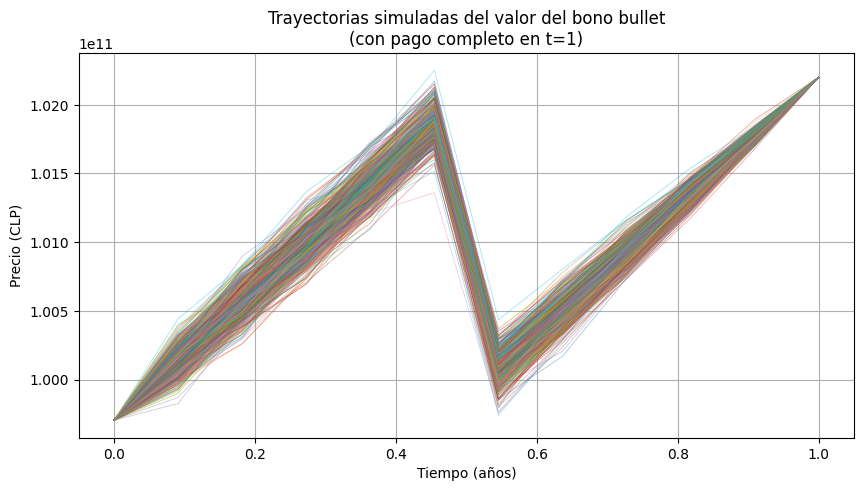

In [260]:
dt = 1/12 # simulaciones mensuales
steps = int(T / dt)

# Funciones de simulación y A, B
def simulate_vasicek(theta, mu, sigma, r0, T, dt, sims):
    N = int(T / dt)
    paths = np.zeros((sims, N))
    for i in range(sims):
        r_path = np.zeros(N)
        r_path[0] = r0
        for t in range(1, N):
            dr = theta*(mu - r_path[t-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
            r_path[t] = r_path[t-1] + dr
        paths[i] = r_path
    return paths

def A_B(a, b, sigma, tau):
    B = (1 - np.exp(-a * tau)) / a
    A = np.exp((b - sigma**2/(2*a**2))*(B - tau) - (sigma**2)*B**2/(4*a))
    return A, B

rate_paths = simulate_vasicek(theta, mu, sigma, r0, T, dt, sims)
price_paths = np.zeros_like(rate_paths)
times = np.linspace(0, T, steps)

for i in range(sims):
    for j, t in enumerate(times):
        price = 0.0
        for CF, Tm in zip(FCs, maturities):
            if Tm >= t:  # incluir fluido en t=T
                tau = max(0, Tm - t)
                A, B = A_B(theta, mu, sigma, tau)
                price += CF * A * np.exp(-B * rate_paths[i, j])
        price_paths[i, j] = price

# plot
plt.figure(figsize=(10, 5))
for i in range(price_paths.shape[0]):
    plt.plot(times, price_paths[i], lw=0.6, alpha=0.4)
plt.title('Trayectorias simuladas del valor del bono bullet\n(con pago completo en t=1)')
plt.xlabel('Tiempo (años)')
plt.ylabel('Precio (CLP)')
plt.grid(True)
plt.show()


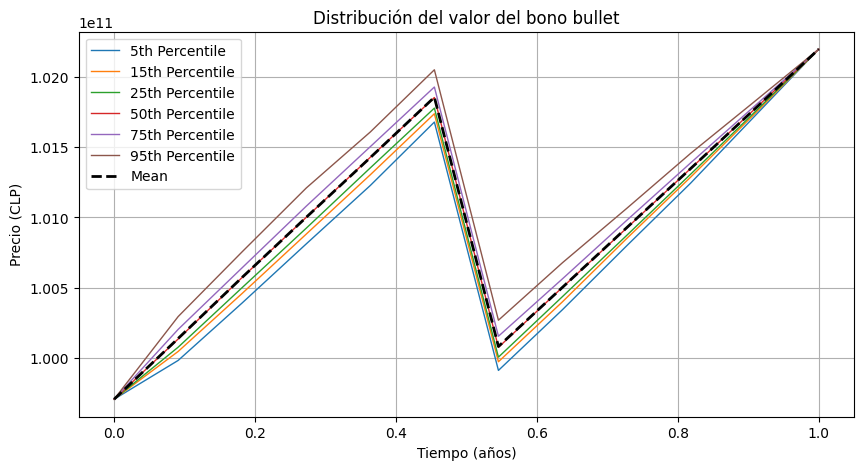

Peor escenario 95% en t=0: 99,703,702,701 CLP


In [262]:
# percentiles y media
percentiles = [5, 15, 25, 50, 75, 95]
pct_values = {p: np.percentile(price_paths, p, axis=0) for p in percentiles}
mean_values = np.mean(price_paths, axis=0)

plt.figure(figsize=(10, 5))
for p, values in pct_values.items():
    plt.plot(times, values, lw=1, label=f'{p}th Percentile')
plt.plot(times, mean_values, lw=2, label='Mean', linestyle='--', color='black')
plt.title('Distribución del valor del bono bullet')
plt.xlabel('Tiempo (años)')
plt.ylabel('Precio (CLP)')
plt.legend()
plt.grid(True)
plt.show()

worst_95_no_prepay = np.percentile(price_paths, 5, axis=0)
print(f"Peor escenario 95% en t=0: {worst_95_no_prepay[0]:,.0f} CLP")


------------------------------

# Pregunta 3
Suponga ahora que su empresa tiene la opción de prepagar la deuda en 6 meses más. Reestime el peor escenario de valor presente al 95% bajo estas condiciones.

In [264]:
# Parámetros
sims, steps = rate_paths.shape
CF1, CF2    = FCs
P_call      = CF2  # reembolso si hay prepago en 6 meses

# factores A y B
A05, B05 = A_B(theta, mu, sigma, 0.5)
A10, B10 = A_B(theta, mu, sigma, 1.0)

# Vector para PV iniciales
PV0 = np.zeros(sims)

# Loop de Monte Carlo para cada trayectoria
for i in range(sims):
    PV_cup = CF1 * A05 * np.exp(-B05 * r0) # Cupón semestral descontado al tiempo 0
        
    idx_half = int(0.5 / dt)  # Tasa simulada en t = 0.5 años
    r_half   = rate_paths[i, idx_half]
    
    # Valor de continuación en t=0.5 (PV desde 0.5 del CF2)
    V_cont = CF2 * A05 * np.exp(-B05 * r_half)
    
    if V_cont > P_call:
        # Emisor pre-paga: recibe P_call en t=0.5
        PV0[i] = PV_cup + P_call * A05 * np.exp(-B05 * r0)
    else:
        # No pre-paga: cobra CF2 en t=1
        PV_CF2_half = CF2 * A10 * np.exp(-B10 * r_half)
        # Descontar ese valor desde 0.5 a 0
        PV0[i] = PV_cup + PV_CF2_half * A05 * np.exp(-B05 * r0)

worst_95_prepago = np.percentile(PV0, 5)
print(f"Peor escenario al 95% considerando prepago en 6 meses: {worst_95_prepago:,.0f} CLP")


Peor escenario al 95% considerando prepago en 6 meses: 97,270,255,680 CLP


---------------------------------------------------------------

# Pregunta 4
Encuentre el valor hoy (18 de junio de 2025) de la opción de prepago que el bono de su empresa tiene.

In [269]:
# Precio sin opción (analítico)
P05 = A05 * np.exp(-B05 * r0)
P10 = A10 * np.exp(-B10 * r0)
P_sinop = CF1*P05 + CF2*P10

# Precio con opción (esperanza de PV0 con prepago)
PV0 = np.zeros(sims)
P_call = CF2
for i in range(sims):
    # cupón semestral descontado
    PV_cup = CF1 * A05 * np.exp(-B05 * r0)
    # tasa a 0.5
    r_half = rate_paths[i, int(0.5/dt)]
    V_cont = CF2 * A05 * np.exp(-B05 * r_half)
    if V_cont > P_call:
        PV0[i] = PV_cup + P_call * A05 * np.exp(-B05 * r0)
    else:
        PV_CF2_half = CF2 * A10 * np.exp(-B10 * r_half)
        PV0[i] = PV_cup + PV_CF2_half * A05 * np.exp(-B05 * r0)

P_op= PV0.mean()

#Valor de la opción de prepago
option_value = P_sinop - P_op

print(f"Valor hoy de la opción de prepago: {option_value:,.0f} CLP")
print(f"Precio no prepagable: {P_sinop:,.0f} CLP")
print(f"Precio prepagable: {P_op:,.0f} CLP")


Valor hoy de la opción de prepago: 2,209,847,792 CLP
Precio no prepagable: 99,703,702,701 CLP
Precio prepagable: 97,493,854,909 CLP


intuición: el valor de la opción de prepago en t=0 es el monto que cuantifica cuánto “pierdes” hoy como inversor si el bono incluye la posibilidad de prepago; o, visto desde el emisor, cuánto “ahorras” gracias a poder recomprar anticipadamente tu propia deuda. La opción de prepago actúa como un “seguro” para el emisor contra descensos de tipos: si los mercados ofrecen tasas más bajas que la cuponal, puede refinanciar a menor costo. 